<a href="https://colab.research.google.com/github/Arshdeep-Yadav/plant/blob/main/PLANT_DISEASE_DETECTION_SYSTEM_FOR_SUSTAINABLE_AGRICULTURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Path to dataset files: /kaggle/input/new-plant-diseases-dataset
Train directory exists: True
Validation directory exists: True
Number of classes: 38
Sample classes: ['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']...

Class distribution sample (top 10):
                                       Class  Count
4                          Soybean___healthy   2022
13                        Apple___Apple_scab   2016
3   Orange___Haunglongbing_(Citrus_greening)   2010
27                           Apple___healthy   2008
22                    Pepper,_bell___healthy   1988
16                         Apple___Black_rot   1987
14    Tomato___Tomato_Yellow_Leaf_Curl_Virus   1961
29                     Potato___Early_blight   1939
24                      Potato___Late_blight   1939
1                           Tomato___

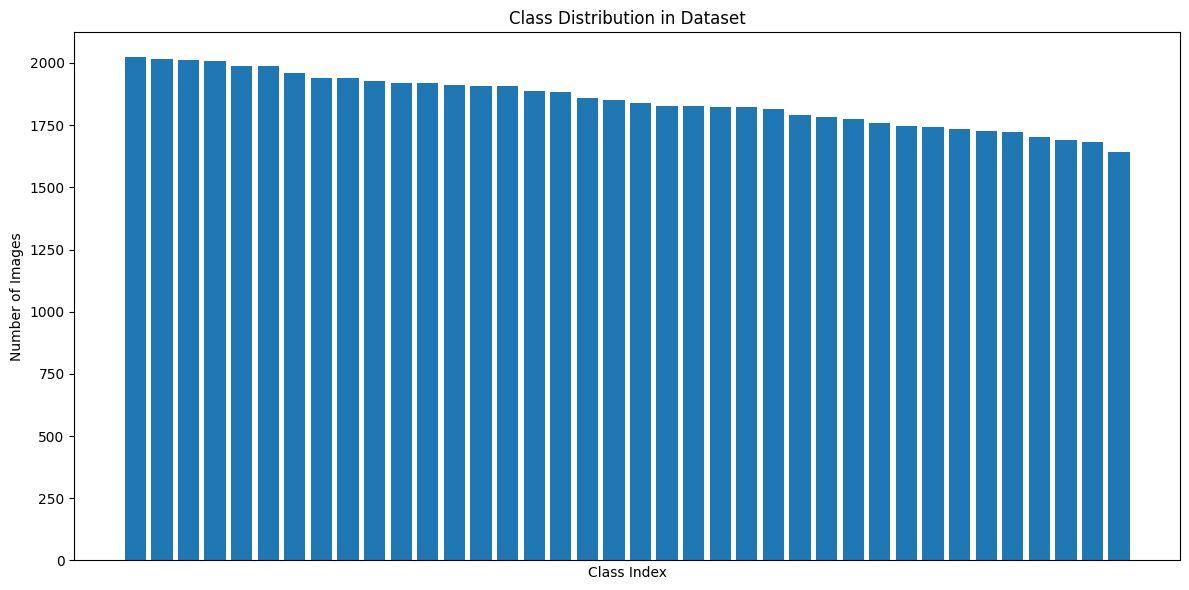

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Total classes: 38


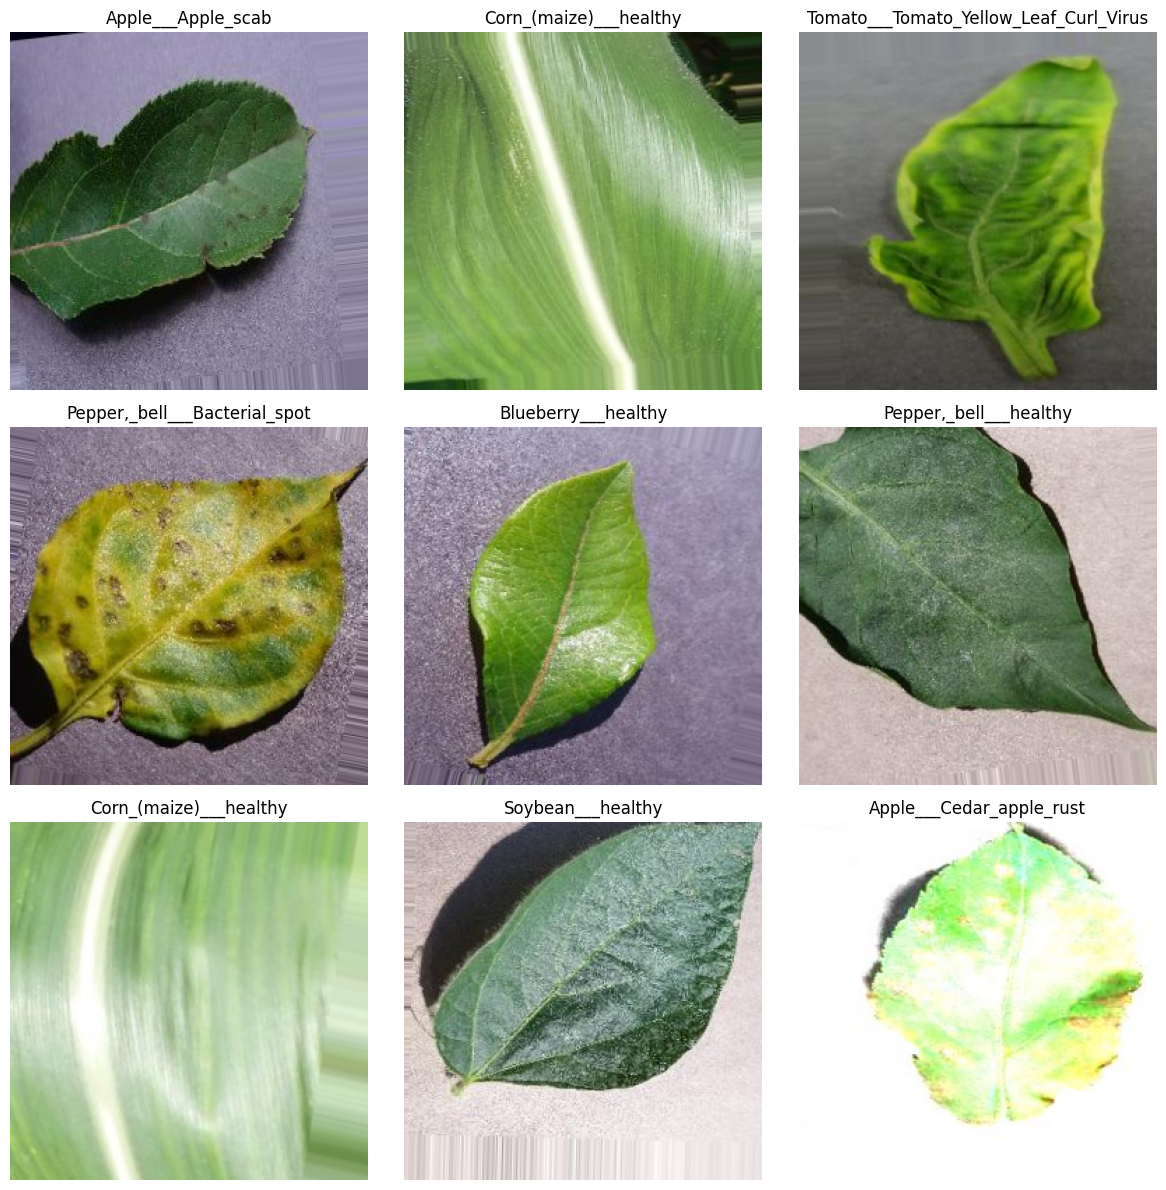

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training ResNet50 model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
  37/2197 ━━━━━━━━━━━━━━━━━━━━ 23:25 650ms/step - accuracy: 0.0490 - loss: 4.7823 - precision: 0.0564 - recall: 0.0098

In [ ]:
# Step 1: Setup and Installation
!pip install opencv-python tensorflow kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50, EfficientNetB3, DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow.keras.backend as K
from google.colab import drive
import kagglehub

# Mount Google Drive
drive.mount('/content/drive')

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Step 2: Download and Explore Dataset
# Download the New Plant Diseases Dataset from Kaggle
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

# Define paths for train and validation data
DATA_DIR = path
TRAIN_DIR = os.path.join(DATA_DIR, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'train')
VALID_DIR = os.path.join(DATA_DIR, 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)', 'valid')

# Verify the directories exist
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Validation directory exists: {os.path.exists(VALID_DIR)}")

# List classes in the dataset
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")
print(f"Sample classes: {classes[:5]}...")

# Count images per class
class_counts = {}
for class_name in classes:
    class_dir = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))

# Convert to DataFrame and display class distribution
class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
class_df = class_df.sort_values('Count', ascending=False)
print("\nClass distribution sample (top 10):")
print(class_df.head(10))

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_df)), class_df['Count'])
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.xticks([])
plt.tight_layout()
plt.show()

# Step 3: Image Preprocessing Pipeline
IMG_SIZE = 256
BATCH_SIZE = 32

# Data Augmentation for training (already augmented dataset, but adding light augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data only gets rescaled
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices and names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"Total classes: {len(class_names)}")

# Visualize sample images
plt.figure(figsize=(12, 12))
for i in range(9):
    # Get a batch of images
    images, labels = next(train_generator)

    # Plot the first image from the batch
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0])
    plt.title(class_names[np.argmax(labels[0])])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Step 4: Model Architecture Implementation
# Define focal loss for handling class imbalance
alpha = 0.25
gamma = 2.0

# Implement focal loss as mentioned in the methodology
def focal_loss_calc(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # Calculate focal loss
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = tf.pow(1.0 - y_true * y_pred - (1.0 - y_true) * (1.0 - y_pred), gamma)

    # Calculate cross entropy
    cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

    # Calculate focal loss
    loss = alpha_factor * modulating_factor * cross_entropy

    # Sum over all classes
    return tf.reduce_sum(loss, axis=-1)

# 1. ResNet50 Model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_output = GlobalAveragePooling2D()(resnet_base.output)
resnet_output = BatchNormalization()(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)
resnet_output = Dense(1024, activation='relu')(resnet_output)
resnet_output = BatchNormalization()(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)
resnet_predictions = Dense(num_classes, activation='softmax')(resnet_output)
resnet_model = Model(inputs=resnet_base.input, outputs=resnet_predictions)

# 2. EfficientNetB3 Model
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
efficientnet_output = GlobalAveragePooling2D()(efficientnet_base.output)
efficientnet_output = BatchNormalization()(efficientnet_output)
efficientnet_output = Dropout(0.5)(efficientnet_output)
efficientnet_output = Dense(1024, activation='relu')(efficientnet_output)
efficientnet_output = BatchNormalization()(efficientnet_output)
efficientnet_output = Dropout(0.5)(efficientnet_output)
efficientnet_predictions = Dense(num_classes, activation='softmax')(efficientnet_output)
efficientnet_model = Model(inputs=efficientnet_base.input, outputs=efficientnet_predictions)

# 3. DenseNet201 Model
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
densenet_output = GlobalAveragePooling2D()(densenet_base.output)
densenet_output = BatchNormalization()(densenet_output)
densenet_output = Dropout(0.5)(densenet_output)
densenet_output = Dense(1024, activation='relu')(densenet_output)
densenet_output = BatchNormalization()(densenet_output)
densenet_output = Dropout(0.5)(densenet_output)
densenet_predictions = Dense(num_classes, activation='softmax')(densenet_output)
densenet_model = Model(inputs=densenet_base.input, outputs=densenet_predictions)

# Freeze early layers for transfer learning
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

for layer in efficientnet_base.layers[:-30]:
    layer.trainable = False

for layer in densenet_base.layers[:-30]:
    layer.trainable = False

# Step 5: Training Setup and Execution
# Define training parameters
EPOCHS = 50
STEPS_PER_EPOCH = len(train_generator)
VALIDATION_STEPS = len(validation_generator)

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# Create callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Create model checkpoints
os.makedirs('/content/drive/MyDrive/plant_disease_models', exist_ok=True)

checkpoint_resnet = ModelCheckpoint(
    '/content/drive/MyDrive/plant_disease_models/resnet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_efficientnet = ModelCheckpoint(
    '/content/drive/MyDrive/plant_disease_models/efficientnet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_densenet = ModelCheckpoint(
    '/content/drive/MyDrive/plant_disease_models/densenet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Compile models
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',  # Use focal_loss_calc for imbalanced classes if needed
    metrics=['accuracy', Precision(), Recall()]
)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Train models one by one (uncomment to train)
print("Training ResNet50 model...")
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr, checkpoint_resnet],
    class_weight=class_weights_dict
)

print("Training EfficientNetB3 model...")
efficientnet_history = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr, checkpoint_efficientnet],
    class_weight=class_weights_dict
)

print("Training DenseNet201 model...")
densenet_history = densenet_model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, reduce_lr, checkpoint_densenet],
    class_weight=class_weights_dict
)

# Step 6: Model Ensemble Implementation
# Load the best saved models
best_resnet = tf.keras.models.load_model('/content/drive/MyDrive/plant_disease_models/resnet_model.h5')
best_efficientnet = tf.keras.models.load_model('/content/drive/MyDrive/plant_disease_models/efficientnet_model.h5')
best_densenet = tf.keras.models.load_model('/content/drive/MyDrive/plant_disease_models/densenet_model.h5')

# Weighted ensemble parameters
resnet_weight = 0.3
efficientnet_weight = 0.4
densenet_weight = 0.3

# Get predictions from validation generator
validation_steps = len(validation_generator)
resnet_predictions = best_resnet.predict(validation_generator, steps=validation_steps)
validation_generator.reset()
efficientnet_predictions = best_efficientnet.predict(validation_generator, steps=validation_steps)
validation_generator.reset()
densenet_predictions = best_densenet.predict(validation_generator, steps=validation_steps)
validation_generator.reset()

# Create weighted ensemble predictions
ensemble_predictions = (
    resnet_predictions * resnet_weight +
    efficientnet_predictions * efficientnet_weight +
    densenet_predictions * densenet_weight
)

# Get the predicted and true classes
ensemble_pred_classes = np.argmax(ensemble_predictions, axis=1)
true_classes = validation_generator.classes[:len(ensemble_pred_classes)]

# Calculate ensemble accuracy
ensemble_accuracy = np.sum(ensemble_pred_classes == true_classes) / len(true_classes)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")

# Step 7: Evaluation and Visualization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Generate classification report
print("Classification Report:")
report = classification_report(true_classes, ensemble_pred_classes, target_names=class_names)
print(report)

# Calculate metrics
accuracy = accuracy_score(true_classes, ensemble_pred_classes)
precision = precision_score(true_classes, ensemble_pred_classes, average='weighted')
recall = recall_score(true_classes, ensemble_pred_classes, average='weighted')
f1 = f1_score(true_classes, ensemble_pred_classes, average='weighted')
kappa = cohen_kappa_score(true_classes, ensemble_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Create confusion matrix visualization
plt.figure(figsize=(20, 20))
cm = confusion_matrix(true_classes, ensemble_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Add text annotations in the cells
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('/content/drive/MyDrive/plant_disease_models/confusion_matrix.png', dpi=300)
plt.show()

# Step 8: Model Interpretability with Grad-CAM
# Get a sample image from validation set
validation_generator.reset()
batch_images, batch_labels = next(validation_generator)
sample_image = batch_images[0]
sample_label = np.argmax(batch_labels[0])
sample_class_name = class_names[sample_label]

# Display the sample image
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"Class: {sample_class_name}")
plt.axis('off')
plt.show()

# Prepare the image for Grad-CAM
img_array = np.expand_dims(sample_image, axis=0)

# Function to generate Grad-CAM heatmap (using ResNet model)
last_conv_layer = best_resnet.get_layer('conv5_block3_out')  # Last convolutional layer in ResNet50

# Create Grad-CAM model
grad_model = tf.keras.models.Model(
    inputs=[best_resnet.inputs],
    outputs=[last_conv_layer.output, best_resnet.output]
)

# Calculate gradients
with tf.GradientTape() as tape:
    conv_output, predictions = grad_model(img_array)
    class_channel = predictions[:, sample_label]

# Gradient of the class with respect to the output feature map
grads = tape.gradient(class_channel, conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the channels by gradient importance
conv_output = conv_output[0]
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = tf.nn.relu(heatmap)  # ReLU to only show positive influences
heatmap = heatmap / tf.reduce_max(heatmap)  # Normalize between 0 and 1
heatmap = heatmap.numpy()

# Create heatmap visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

# Superimposed image
img = sample_image.copy()
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
superimposed = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_colored, 0.4, 0)

plt.subplot(1, 3, 3)
plt.imshow(superimposed / 255.0)
plt.title("Grad-CAM Overlay")
plt.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/plant_disease_models/gradcam_visualization.png', dpi=300)
plt.show()

print("Plant disease detection system implementation complete.")
